In [ ]:
!pip install lime
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
import os
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Projects/AL-ZHEIME Main-Project/XAIModels/AD_XAI')

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
def grad_cam(model, image, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)

    return cam

The Grad-CAM (Gradient-weighted Class Activation Mapping) method is a technique used to visualize the regions of an input image that are important for predicting a particular class. It highlights the regions of the image that contribute the most to the prediction made by the neural network.

1. **Inputs**:
   - model : The trained neural network model.
   - image : The input image for which we want to generate the Grad-CAM heatmap.
   - class_index : The index of the predicted class for the input image.
   - layer_name : The name of the last convolutional layer in the model.

2. **Gradient Tape**:
   - First, we create a gradient tape to record the operations for automatic differentiation. This allows us to calculate the gradients of the predicted class score with respect to the output feature map of the specified convolutional layer.

3. **Forward Pass**:
   - We pass the input image through the model to obtain the output feature map of the specified convolutional layer and the model's predictions.

4. **Calculate Loss**:
   - Using the gradient tape, we compute the loss as the predicted score of the target class. This loss serves as a measure of how much the output of the target class needs to be increased to maximize the predicted score.

5. **Compute Gradients**:
   - We compute the gradients of the predicted score with respect to the output feature map of the convolutional layer. These gradients indicate the importance of each feature map unit for predicting the target class.

6. **Guided Gradients**:
   - We filter the gradients to only retain positive gradients, as they indicate regions where increasing the feature map values will increase the predicted score for the target class.

7. **Weighted Gradients**:
   - We compute the weighted average of the feature maps using the guided gradients as weights. This highlights the regions of the feature maps that are most relevant for predicting the target class.

8. **Generate Grad-CAM**:
   - Finally, we compute the Grad-CAM heatmap by taking the element-wise maximum between the weighted sum and zero. This ensures that only positive contributions to the prediction are considered in the heatmap.

9. **Output**:
   - The function returns the Grad-CAM heatmap, which highlights the regions of the input image that are most influential in predicting the target class.


In [ ]:
# Function to get the last convolutional layer
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [ ]:
# Get the last convolutional layer
last_conv_layer = get_last_conv_layer(model)

In [ ]:
from skimage.color import gray2rgb

def generate_lime_explanation(model, image):
    explanation = explainer.explain_instance(image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
    lime_explanation, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Convert Lime explanation to RGB format
    lime_explanation_rgb = gray2rgb(lime_explanation)

    # Overlay Lime explanation on the original image using the mask
    marked_explanation = mark_boundaries(image[0], mask)

    return marked_explanation

In [ ]:
# def generate_lime_explanation(model, image, class_index):
#     explanation = explainer.explain_instance(image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
#     return mark_boundaries(temp / 2 + 0.5, mask)

The Lime (Local Interpretable Model-agnostic Explanations) method is used to explain the predictions of complex machine learning models by approximating them with locally linear surrogate models. Lime provides explanations for individual predictions by perturbing the input data and observing the changes in the model's predictions.

1. **Inputs**:
   - model : The trained neural network model.
   - image : The input image for which we want to generate the Lime explanation.
   - class_index : The index of the predicted class for the input image.

2. **Explanation Generation**:
   - We create an instance of the LimeImageExplainer class, which is provided by the Lime library for generating explanations for image data.
   - Using this explainer, we generate an explanation for the input image by calling the **explain_instance** method. This method perturbs the input image and observes the changes in the model's predictions to understand the importance of different image regions for the predicted class.

3. **Explanation Visualization**:
   - The Lime library provides functionality to visualize the generated explanations. We use the **get_image_and_mask** method to obtain an image representation of the explanation along with a binary mask highlighting the important regions.
   - positive_only as True : to only show the regions that positively contribute to the predicted class.
   - num_features : to control the number of features (important image regions) to include in the explanation.

4. **Output**:
   - The function returns the Lime explanation as an image along with the corresponding binary mask. This explanation highlights the regions of the input image that are most influential in predicting the target class according to the Lime method.

In [ ]:
# Upload your image
uploaded = files.upload()

Saving 26 (70).jpg to 26 (70).jpg


In [ ]:
for filename in uploaded.keys():
    img = cv2.imread(filename)
    img = cv2.resize(img, (176, 208))  # Resize to match model input shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img.astype('float32') / 255  # Normalize
    class_labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
    class_index = np.argmax(model.predict(img))
    predicted_class = class_labels[np.argmax(model.predict(img))]

    # # Generate Lime explanation
    # explanation = explainer.explain_instance(img[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
    # lime_explanation, _ = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    lime_explanation = generate_lime_explanation(model, img)

    # Generate Grad-CAM
    grad_cam_result = grad_cam(model, img, class_index, last_conv_layer)

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 137ms/step


In [ ]:
print(class_index)
print(predicted_class)

2
NonDemented


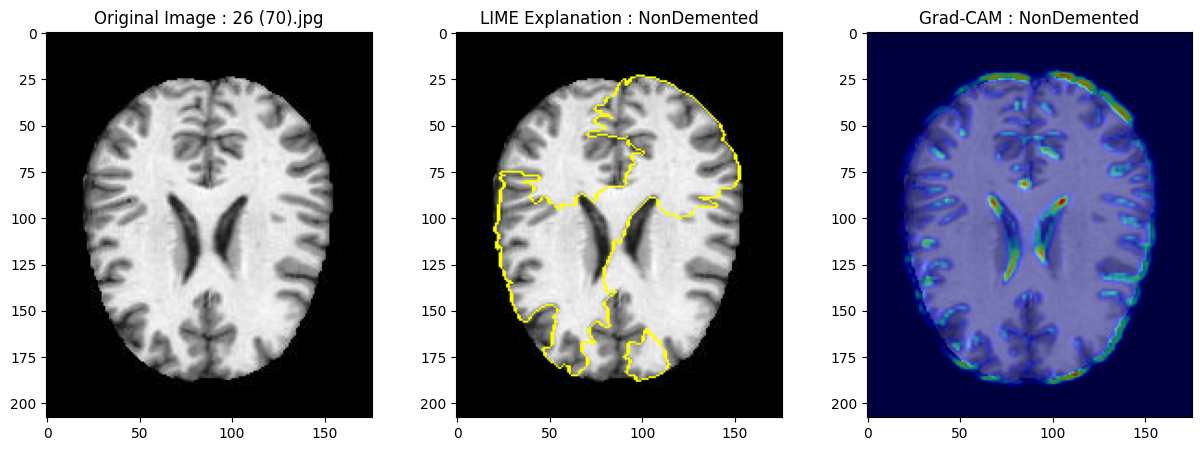

In [ ]:
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[0])
ax[0].set_title(f'Original Image : {filename}')

ax[1].imshow(lime_explanation)
ax[1].set_title(f'LIME Explanation : {predicted_class}')

ax[2].imshow(img[0])
ax[2].imshow(cv2.resize(grad_cam_result, (img.shape[2], img.shape[1])), alpha=0.5, cmap='jet')
ax[2].set_title(f'Grad-CAM : {predicted_class}')

plt.show()